In [179]:
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.definitions.instruments import CandlestickGranularity

import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
import os

## Backtesting
In this notebook, we set up the basic structure of testing the algorithm. \
The algorithm basically works as follows: \
<ins>Inputs:</ins> 
- A history of an instrument, consisting of:
    - Historical values, and
    - their timestamps
- The current value of the same instrument,
    - Including timestamp
- boolean value for current ownership of the quote currency

<ins>Outputs:</ins>
- Prediction whether value will go up/down
- and/or prediction whether quote currency should be bought/sold/kept with base currency (the algorithm should do the trading end-to-end, so use both) (kept means no buying nor selling)

In [162]:
# Use a default set of historical values for now (from History.ipynb)

# Helper function to convert datetime string to datetime object
def to_datetime(t):
    return datetime.datetime.strptime(t[0:-4], '%Y-%m-%dT%H:%M:%S.%f') 
# granularities = CandlestickGranularity().definitions.keys()
# Define parameters
granularity = 'M2'
From = "2017-01-01"
To = "2017-12-31"
i = 'EUR_USD' # Instrument - first is base currency, second quote currency
                                # I think base should always be EUR for this acct
params = {
    'from': From,
    'to': To,
    'granularity': 'H2',
}
# Compile request
r = instruments.InstrumentsCandles(instrument=i, params=params)

# Define API with our access token (for demo acct)
api = API(access_token='378d83764609aa3a4eb262663b7c02ef-482ed5696d2a3cede7fca4aa7ded1c76')

# Request candles
rv = api.request(r)

history_val0 = [float(candle['mid']['c']) for candle in rv['candles']] # center? values
timestamps0 = [to_datetime(candle['time']).timestamp() for candle in rv['candles']] # time values
# dates = [to_datetime(candle['time']).date() for candle in rv['candles']]



In [163]:
# Use a default set of historical values for now (from History.ipynb)

# Helper function to convert datetime string to datetime object
def to_datetime(t):
    return datetime.datetime.strptime(t[0:-4], '%Y-%m-%dT%H:%M:%S.%f') 
# granularities = CandlestickGranularity().definitions.keys()
# Define parameters
granularity = 'M2'
From = "2018-01-01"
To = "2018-12-31"
i = 'EUR_USD' # Instrument - first is base currency, second quote currency
                                # I think base should always be EUR for this acct
params = {
    'from': From,
    'to': To,
    'granularity': 'H2',
}
# Compile request
r = instruments.InstrumentsCandles(instrument=i, params=params)

# Define API with our access token (for demo acct)
api = API(access_token='378d83764609aa3a4eb262663b7c02ef-482ed5696d2a3cede7fca4aa7ded1c76')

# Request candles
rv = api.request(r)

history_val1 = [float(candle['mid']['c']) for candle in rv['candles']] # center? values
timestamps1 = [to_datetime(candle['time']).timestamp() for candle in rv['candles']] # time values
# dates = [to_datetime(candle['time']).date() for candle in rv['candles']]



In [175]:
# Use a default set of historical values for now (from History.ipynb)

# Helper function to convert datetime string to datetime object
def to_datetime(t):
    return datetime.datetime.strptime(t[0:-4], '%Y-%m-%dT%H:%M:%S.%f') 
# granularities = CandlestickGranularity().definitions.keys()
# Define parameters
granularity = 'M2'
From = "2019-01-01"
To = "2020-01-01"
i = 'EUR_USD' # Instrument - first is base currency, second quote currency
                                # I think base should always be EUR for this acct
params = {
    'from': From,
    'to': To,
    'granularity': 'H2',
}
# Compile request
r = instruments.InstrumentsCandles(instrument=i, params=params)

# Define API with our access token (for demo acct)
api = API(access_token='378d83764609aa3a4eb262663b7c02ef-482ed5696d2a3cede7fca4aa7ded1c76')

# Request candles
rv = api.request(r)

history_val2 = [float(candle['mid']['c']) for candle in rv['candles']] # center? values
timestamps2 = [to_datetime(candle['time']).timestamp() for candle in rv['candles']] # time values
# dates = [to_datetime(candle['time']).date() for candle in rv['candles']]

history_val = [*history_val0, *history_val1, *history_val2]
timestamps = [*timestamps0, *timestamps1, *timestamps2]

In [165]:
class History():
    def __init__(self, values, timestamps):
        self.values = values
        self.timestamps = timestamps

In [166]:
print(len(history_val))

9306


In [167]:
history = History(history_val[0:9000], timestamps[0:9000]) # train set
history_test = History(history_val[9001:], timestamps[9001:]) # test set
current = History([current_value], [current_timestamp])

In [168]:
# Markov kernel: Probability of increase (over minimum), decrease (over minimum), or neither (within minimum)

minimum = 0.0002

min_pos = minimum # Minimum positive increase
min_neg = minimum # Minimum negative increase

In [169]:
class MarkovKernel(nn.Module):
    # Simple neural network for markov kernel
    def __init__(self, hidden_size):
        super(MarkovKernel, self).__init__()
        layer_list = [
            nn.Linear(1, hidden_size[0]), 
            nn.Tanh(),]
        for hidden_layer_index in np.arange(1, len( hidden_size ) ):
          layer_list.append( nn.Linear( hidden_size[hidden_layer_index-1], \
            hidden_size[hidden_layer_index]  ) ) # take in_features out_features into account
          layer_list.append( nn.Tanh() ) 
        
        layer_list.append( nn.Linear(hidden_size[-1],  3 ) )
        layer_list.append(nn.Softmax())
        
        self.model = nn.Sequential( *layer_list ) #Unpacks list for sequential
        
    def forward(self, value):
        classification = self.model(value)
        return classification
    
    def classify(self, history):
        classification = self.model(history[-1])
        return classification
        

In [177]:
model = MarkovKernel([16])
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(markov_kernel.parameters(), lr=1e-3)
no_epochs = 2

In [178]:
imp_one_hot = torch.FloatTensor(3)

# # In your for loop
# y_onehot.zero_()
# y_onehot.scatter_(1, y, 1)
for epoch in range(no_epochs):
    for index, target_value in enumerate(history.values[1:]):
        optimizer.zero_grad()

        previous_value = history.values[index-1]
        delta = target_value - previous_value

        if delta>-min_neg and delta<min_pos:
            improvement = 1 # Class is 1 (no difference)
        elif delta>=-min_pos:
            improvement = 0 # Class is 0 (positive difference)
        else:
            improvement = 2 # Class is 2 (negative difference)


        imp_one_hot.zero_()

        imp_one_hot.scatter_(0, torch.tensor([improvement]), 1)

        classification = model(torch.Tensor([[previous_value]]))

        loss = loss_fn(classification, torch.tensor([improvement]))

        loss.backward()
        optimizer.step()

        if index % 10 == 0:
            print(f"Step {index} - Loss: {loss} - prediction {classification[0,improvement]} - improvement {improvement}")
#     print(value, previous_value, delta)

Step 0 - Loss: -0.4793016314506531 - prediction 0.4793016314506531 - improvement 2
Step 10 - Loss: -0.47566935420036316 - prediction 0.47566935420036316 - improvement 2
Step 20 - Loss: -0.32767489552497864 - prediction 0.32767489552497864 - improvement 0
Step 30 - Loss: -0.3275674879550934 - prediction 0.3275674879550934 - improvement 0
Step 40 - Loss: -0.327438622713089 - prediction 0.327438622713089 - improvement 0
Step 50 - Loss: -0.47639063000679016 - prediction 0.47639063000679016 - improvement 2
Step 60 - Loss: -0.327457457780838 - prediction 0.327457457780838 - improvement 0
Step 70 - Loss: -0.47651129961013794 - prediction 0.47651129961013794 - improvement 2
Step 80 - Loss: -0.3275533616542816 - prediction 0.3275533616542816 - improvement 0
Step 90 - Loss: -0.32734161615371704 - prediction 0.32734161615371704 - improvement 0
Step 100 - Loss: -0.32738178968429565 - prediction 0.32738178968429565 - improvement 0
Step 110 - Loss: -0.1957419067621231 - prediction 0.1957419067621231

Step 1100 - Loss: -0.4784850776195526 - prediction 0.4784850776195526 - improvement 2
Step 1110 - Loss: -0.47847646474838257 - prediction 0.47847646474838257 - improvement 2
Step 1120 - Loss: -0.47843098640441895 - prediction 0.47843098640441895 - improvement 2
Step 1130 - Loss: -0.3268667757511139 - prediction 0.3268667757511139 - improvement 0
Step 1140 - Loss: -0.32678133249282837 - prediction 0.32678133249282837 - improvement 0
Step 1150 - Loss: -0.3266105055809021 - prediction 0.3266105055809021 - improvement 0
Step 1160 - Loss: -0.3265290856361389 - prediction 0.3265290856361389 - improvement 0
Step 1170 - Loss: -0.4799922704696655 - prediction 0.4799922704696655 - improvement 2
Step 1180 - Loss: -0.32654857635498047 - prediction 0.32654857635498047 - improvement 0
Step 1190 - Loss: -0.32642054557800293 - prediction 0.32642054557800293 - improvement 0
Step 1200 - Loss: -0.326333612203598 - prediction 0.326333612203598 - improvement 0
Step 1210 - Loss: -0.4803856611251831 - predic

Step 2180 - Loss: -0.48499587178230286 - prediction 0.48499587178230286 - improvement 2
Step 2190 - Loss: -0.48459550738334656 - prediction 0.48459550738334656 - improvement 2
Step 2200 - Loss: -0.32515254616737366 - prediction 0.32515254616737366 - improvement 0
Step 2210 - Loss: -0.4848250448703766 - prediction 0.4848250448703766 - improvement 2
Step 2220 - Loss: -0.3250778615474701 - prediction 0.3250778615474701 - improvement 0
Step 2230 - Loss: -0.32504338026046753 - prediction 0.32504338026046753 - improvement 0
Step 2240 - Loss: -0.32501089572906494 - prediction 0.32501089572906494 - improvement 0
Step 2250 - Loss: -0.3251507878303528 - prediction 0.3251507878303528 - improvement 0
Step 2260 - Loss: -0.3250679075717926 - prediction 0.3250679075717926 - improvement 0
Step 2270 - Loss: -0.3251248300075531 - prediction 0.3251248300075531 - improvement 0
Step 2280 - Loss: -0.32526713609695435 - prediction 0.32526713609695435 - improvement 0
Step 2290 - Loss: -0.3253832161426544 - pr

Step 3240 - Loss: -0.4865867793560028 - prediction 0.4865867793560028 - improvement 2
Step 3250 - Loss: -0.48656922578811646 - prediction 0.48656922578811646 - improvement 2
Step 3260 - Loss: -0.48675447702407837 - prediction 0.48675447702407837 - improvement 2
Step 3270 - Loss: -0.3245815932750702 - prediction 0.3245815932750702 - improvement 0
Step 3280 - Loss: -0.4866684079170227 - prediction 0.4866684079170227 - improvement 2
Step 3290 - Loss: -0.3244607150554657 - prediction 0.3244607150554657 - improvement 0
Step 3300 - Loss: -0.3242935240268707 - prediction 0.3242935240268707 - improvement 0
Step 3310 - Loss: -0.48796749114990234 - prediction 0.48796749114990234 - improvement 2
Step 3320 - Loss: -0.4877346158027649 - prediction 0.4877346158027649 - improvement 2
Step 3330 - Loss: -0.4875023663043976 - prediction 0.4875023663043976 - improvement 2
Step 3340 - Loss: -0.4873381555080414 - prediction 0.4873381555080414 - improvement 2
Step 3350 - Loss: -0.3242737650871277 - predicti

Step 4280 - Loss: -0.48402541875839233 - prediction 0.48402541875839233 - improvement 2
Step 4290 - Loss: -0.4836982190608978 - prediction 0.4836982190608978 - improvement 2
Step 4300 - Loss: -0.4839368462562561 - prediction 0.4839368462562561 - improvement 2
Step 4310 - Loss: -0.32539117336273193 - prediction 0.32539117336273193 - improvement 0
Step 4320 - Loss: -0.32554006576538086 - prediction 0.32554006576538086 - improvement 0
Step 4330 - Loss: -0.32548198103904724 - prediction 0.32548198103904724 - improvement 0
Step 4340 - Loss: -0.4835643768310547 - prediction 0.4835643768310547 - improvement 2
Step 4350 - Loss: -0.4835497736930847 - prediction 0.4835497736930847 - improvement 2
Step 4360 - Loss: -0.19136685132980347 - prediction 0.19136685132980347 - improvement 1
Step 4370 - Loss: -0.4824545979499817 - prediction 0.4824545979499817 - improvement 2
Step 4380 - Loss: -0.1912156045436859 - prediction 0.1912156045436859 - improvement 1
Step 4390 - Loss: -0.19118022918701172 - pre

Step 5340 - Loss: -0.4833049476146698 - prediction 0.4833049476146698 - improvement 2
Step 5350 - Loss: -0.4838138222694397 - prediction 0.4838138222694397 - improvement 2
Step 5360 - Loss: -0.48394790291786194 - prediction 0.48394790291786194 - improvement 2
Step 5370 - Loss: -0.3254519999027252 - prediction 0.3254519999027252 - improvement 0
Step 5380 - Loss: -0.4837087094783783 - prediction 0.4837087094783783 - improvement 2
Step 5390 - Loss: -0.4837939739227295 - prediction 0.4837939739227295 - improvement 2
Step 5400 - Loss: -0.4837069809436798 - prediction 0.4837069809436798 - improvement 2
Step 5410 - Loss: -0.19116955995559692 - prediction 0.19116955995559692 - improvement 1
Step 5420 - Loss: -0.48290130496025085 - prediction 0.48290130496025085 - improvement 2
Step 5430 - Loss: -0.32571175694465637 - prediction 0.32571175694465637 - improvement 0
Step 5440 - Loss: -0.4826737344264984 - prediction 0.4826737344264984 - improvement 2
Step 5450 - Loss: -0.48251786828041077 - predi

Step 6420 - Loss: -0.32603806257247925 - prediction 0.32603806257247925 - improvement 0
Step 6430 - Loss: -0.32599517703056335 - prediction 0.32599517703056335 - improvement 0
Step 6440 - Loss: -0.3259839117527008 - prediction 0.3259839117527008 - improvement 0
Step 6450 - Loss: -0.32591360807418823 - prediction 0.32591360807418823 - improvement 0
Step 6460 - Loss: -0.4819287657737732 - prediction 0.4819287657737732 - improvement 2
Step 6470 - Loss: -0.4820707142353058 - prediction 0.4820707142353058 - improvement 2
Step 6480 - Loss: -0.325973778963089 - prediction 0.325973778963089 - improvement 0
Step 6490 - Loss: -0.4818359613418579 - prediction 0.4818359613418579 - improvement 2
Step 6500 - Loss: -0.48163947463035583 - prediction 0.48163947463035583 - improvement 2
Step 6510 - Loss: -0.19247739017009735 - prediction 0.19247739017009735 - improvement 1
Step 6520 - Loss: -0.48132845759391785 - prediction 0.48132845759391785 - improvement 2
Step 6530 - Loss: -0.4813153147697449 - pred

Step 7490 - Loss: -0.3264729976654053 - prediction 0.3264729976654053 - improvement 0
Step 7500 - Loss: -0.3264326751232147 - prediction 0.3264326751232147 - improvement 0
Step 7510 - Loss: -0.19296732544898987 - prediction 0.19296732544898987 - improvement 1
Step 7520 - Loss: -0.3262978494167328 - prediction 0.3262978494167328 - improvement 0
Step 7530 - Loss: -0.32636168599128723 - prediction 0.32636168599128723 - improvement 0
Step 7540 - Loss: -0.48099496960639954 - prediction 0.48099496960639954 - improvement 2
Step 7550 - Loss: -0.3261962831020355 - prediction 0.3261962831020355 - improvement 0
Step 7560 - Loss: -0.3262315094470978 - prediction 0.3262315094470978 - improvement 0
Step 7570 - Loss: -0.4811394214630127 - prediction 0.4811394214630127 - improvement 2
Step 7580 - Loss: -0.3261750042438507 - prediction 0.3261750042438507 - improvement 0
Step 7590 - Loss: -0.32624736428260803 - prediction 0.32624736428260803 - improvement 0
Step 7600 - Loss: -0.19284217059612274 - predi

Step 8590 - Loss: -0.32677963376045227 - prediction 0.32677963376045227 - improvement 0
Step 8600 - Loss: -0.32680994272232056 - prediction 0.32680994272232056 - improvement 0
Step 8610 - Loss: -0.32678335905075073 - prediction 0.32678335905075073 - improvement 0
Step 8620 - Loss: -0.4792979657649994 - prediction 0.4792979657649994 - improvement 2
Step 8630 - Loss: -0.19388629496097565 - prediction 0.19388629496097565 - improvement 1
Step 8640 - Loss: -0.32670754194259644 - prediction 0.32670754194259644 - improvement 0
Step 8650 - Loss: -0.3266935646533966 - prediction 0.3266935646533966 - improvement 0
Step 8660 - Loss: -0.4794246554374695 - prediction 0.4794246554374695 - improvement 2
Step 8670 - Loss: -0.19371996819972992 - prediction 0.19371996819972992 - improvement 1
Step 8680 - Loss: -0.3265429139137268 - prediction 0.3265429139137268 - improvement 0
Step 8690 - Loss: -0.32651403546333313 - prediction 0.32651403546333313 - improvement 0
Step 8700 - Loss: -0.4802323877811432 - 

Step 690 - Loss: -0.3271191418170929 - prediction 0.3271191418170929 - improvement 0
Step 700 - Loss: -0.3271365463733673 - prediction 0.3271365463733673 - improvement 0
Step 710 - Loss: -0.47827550768852234 - prediction 0.47827550768852234 - improvement 2
Step 720 - Loss: -0.478380024433136 - prediction 0.478380024433136 - improvement 2
Step 730 - Loss: -0.4781986176967621 - prediction 0.4781986176967621 - improvement 2
Step 740 - Loss: -0.4777686297893524 - prediction 0.4777686297893524 - improvement 2
Step 750 - Loss: -0.47758060693740845 - prediction 0.47758060693740845 - improvement 2
Step 760 - Loss: -0.3272852301597595 - prediction 0.3272852301597595 - improvement 0
Step 770 - Loss: -0.3272891044616699 - prediction 0.3272891044616699 - improvement 0
Step 780 - Loss: -0.19551846385002136 - prediction 0.19551846385002136 - improvement 1
Step 790 - Loss: -0.3273092210292816 - prediction 0.3273092210292816 - improvement 0
Step 800 - Loss: -0.4771650731563568 - prediction 0.477165073

Step 1770 - Loss: -0.48357197642326355 - prediction 0.48357197642326355 - improvement 2
Step 1780 - Loss: -0.32555481791496277 - prediction 0.32555481791496277 - improvement 0
Step 1790 - Loss: -0.48365500569343567 - prediction 0.48365500569343567 - improvement 2
Step 1800 - Loss: -0.48423531651496887 - prediction 0.48423531651496887 - improvement 2
Step 1810 - Loss: -0.48401492834091187 - prediction 0.48401492834091187 - improvement 2
Step 1820 - Loss: -0.32530826330184937 - prediction 0.32530826330184937 - improvement 0
Step 1830 - Loss: -0.3252747654914856 - prediction 0.3252747654914856 - improvement 0
Step 1840 - Loss: -0.3252108097076416 - prediction 0.3252108097076416 - improvement 0
Step 1850 - Loss: -0.32537615299224854 - prediction 0.32537615299224854 - improvement 0
Step 1860 - Loss: -0.3253609538078308 - prediction 0.3253609538078308 - improvement 0
Step 1870 - Loss: -0.1908523589372635 - prediction 0.1908523589372635 - improvement 1
Step 1880 - Loss: -0.19088295102119446 -

Step 2830 - Loss: -0.48453354835510254 - prediction 0.48453354835510254 - improvement 2
Step 2840 - Loss: -0.48437702655792236 - prediction 0.48437702655792236 - improvement 2
Step 2850 - Loss: -0.4843636453151703 - prediction 0.4843636453151703 - improvement 2
Step 2860 - Loss: -0.3251582384109497 - prediction 0.3251582384109497 - improvement 0
Step 2870 - Loss: -0.4845544099807739 - prediction 0.4845544099807739 - improvement 2
Step 2880 - Loss: -0.3252749443054199 - prediction 0.3252749443054199 - improvement 0
Step 2890 - Loss: -0.4841923415660858 - prediction 0.4841923415660858 - improvement 2
Step 2900 - Loss: -0.4841248691082001 - prediction 0.4841248691082001 - improvement 2
Step 2910 - Loss: -0.48394155502319336 - prediction 0.48394155502319336 - improvement 2
Step 2920 - Loss: -0.19080713391304016 - prediction 0.19080713391304016 - improvement 1
Step 2930 - Loss: -0.3254013955593109 - prediction 0.3254013955593109 - improvement 0
Step 2940 - Loss: -0.4839397668838501 - predic

Step 3910 - Loss: -0.48657655715942383 - prediction 0.48657655715942383 - improvement 2
Step 3920 - Loss: -0.3245750963687897 - prediction 0.3245750963687897 - improvement 0
Step 3930 - Loss: -0.3244992792606354 - prediction 0.3244992792606354 - improvement 0
Step 3940 - Loss: -0.48700326681137085 - prediction 0.48700326681137085 - improvement 2
Step 3950 - Loss: -0.3243577480316162 - prediction 0.3243577480316162 - improvement 0
Step 3960 - Loss: -0.48727959394454956 - prediction 0.48727959394454956 - improvement 2
Step 3970 - Loss: -0.32443001866340637 - prediction 0.32443001866340637 - improvement 0
Step 3980 - Loss: -0.487055242061615 - prediction 0.487055242061615 - improvement 2
Step 3990 - Loss: -0.32440274953842163 - prediction 0.32440274953842163 - improvement 0
Step 4000 - Loss: -0.18836189806461334 - prediction 0.18836189806461334 - improvement 1
Step 4010 - Loss: -0.18841461837291718 - prediction 0.18841461837291718 - improvement 1
Step 4020 - Loss: -0.4873652160167694 - pr

Step 4980 - Loss: -0.32571282982826233 - prediction 0.32571282982826233 - improvement 0
Step 4990 - Loss: -0.48281586170196533 - prediction 0.48281586170196533 - improvement 2
Step 5000 - Loss: -0.4819721281528473 - prediction 0.4819721281528473 - improvement 2
Step 5010 - Loss: -0.32610946893692017 - prediction 0.32610946893692017 - improvement 0
Step 5020 - Loss: -0.19230212271213531 - prediction 0.19230212271213531 - improvement 1
Step 5030 - Loss: -0.48129498958587646 - prediction 0.48129498958587646 - improvement 2
Step 5040 - Loss: -0.3261502981185913 - prediction 0.3261502981185913 - improvement 0
Step 5050 - Loss: -0.192464679479599 - prediction 0.192464679479599 - improvement 1
Step 5060 - Loss: -0.32605940103530884 - prediction 0.32605940103530884 - improvement 0
Step 5070 - Loss: -0.4817889630794525 - prediction 0.4817889630794525 - improvement 2
Step 5080 - Loss: -0.32584038376808167 - prediction 0.32584038376808167 - improvement 0
Step 5090 - Loss: -0.3257553279399872 - pr

Step 6070 - Loss: -0.3261478841304779 - prediction 0.3261478841304779 - improvement 0
Step 6080 - Loss: -0.48099076747894287 - prediction 0.48099076747894287 - improvement 2
Step 6090 - Loss: -0.32621148228645325 - prediction 0.32621148228645325 - improvement 0
Step 6100 - Loss: -0.48138701915740967 - prediction 0.48138701915740967 - improvement 2
Step 6110 - Loss: -0.32611677050590515 - prediction 0.32611677050590515 - improvement 0
Step 6120 - Loss: -0.48178184032440186 - prediction 0.48178184032440186 - improvement 2
Step 6130 - Loss: -0.32597315311431885 - prediction 0.32597315311431885 - improvement 0
Step 6140 - Loss: -0.4817996621131897 - prediction 0.4817996621131897 - improvement 2
Step 6150 - Loss: -0.32606858015060425 - prediction 0.32606858015060425 - improvement 0
Step 6160 - Loss: -0.48169252276420593 - prediction 0.48169252276420593 - improvement 2
Step 6170 - Loss: -0.32613545656204224 - prediction 0.32613545656204224 - improvement 0
Step 6180 - Loss: -0.481846690177917

Step 7140 - Loss: -0.32631900906562805 - prediction 0.32631900906562805 - improvement 0
Step 7150 - Loss: -0.19295445084571838 - prediction 0.19295445084571838 - improvement 1
Step 7160 - Loss: -0.19309286773204803 - prediction 0.19309286773204803 - improvement 1
Step 7170 - Loss: -0.1933693140745163 - prediction 0.1933693140745163 - improvement 1
Step 7180 - Loss: -0.48005038499832153 - prediction 0.48005038499832153 - improvement 2
Step 7190 - Loss: -0.3264866769313812 - prediction 0.3264866769313812 - improvement 0
Step 7200 - Loss: -0.4802226424217224 - prediction 0.4802226424217224 - improvement 2
Step 7210 - Loss: -0.3264172673225403 - prediction 0.3264172673225403 - improvement 0
Step 7220 - Loss: -0.19309113919734955 - prediction 0.19309113919734955 - improvement 1
Step 7230 - Loss: -0.32640647888183594 - prediction 0.32640647888183594 - improvement 0
Step 7240 - Loss: -0.4802987575531006 - prediction 0.4802987575531006 - improvement 2
Step 7250 - Loss: -0.32646629214286804 - p

Step 8230 - Loss: -0.3265712559223175 - prediction 0.3265712559223175 - improvement 0
Step 8240 - Loss: -0.1936536282300949 - prediction 0.1936536282300949 - improvement 1
Step 8250 - Loss: -0.3266069293022156 - prediction 0.3266069293022156 - improvement 0
Step 8260 - Loss: -0.326649010181427 - prediction 0.326649010181427 - improvement 0
Step 8270 - Loss: -0.47945263981819153 - prediction 0.47945263981819153 - improvement 2
Step 8280 - Loss: -0.47905397415161133 - prediction 0.47905397415161133 - improvement 2
Step 8290 - Loss: -0.32683977484703064 - prediction 0.32683977484703064 - improvement 0
Step 8300 - Loss: -0.194153293967247 - prediction 0.194153293967247 - improvement 1
Step 8310 - Loss: -0.19388806819915771 - prediction 0.19388806819915771 - improvement 1
Step 8320 - Loss: -0.4794721007347107 - prediction 0.4794721007347107 - improvement 2
Step 8330 - Loss: -0.4794647991657257 - prediction 0.4794647991657257 - improvement 2
Step 8340 - Loss: -0.3266814947128296 - prediction

TypeError: save() missing 2 required positional arguments: 'obj' and 'f'

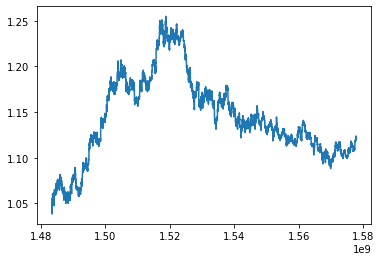

In [176]:
plt.plot(timestamps,history_val)

In [181]:
# Store state dict
if not os.path.isdir('Pre-trained Models'):
    os.mkdir('Pre-trained Models')

model_path = 'models/markov_kernel_n1.pt'
    
torch.save(model.state_dict(), model_path)
